In [1]:
#load necessary data
import sys
import scipy.io
import pandas as pd
data = scipy.io.loadmat('option_data.mat')
price = pd.read_csv('50ETF(20150209-20180704).CSV')
columns = ['Date','Code','Name','Due','Exercise Price','Opening','Clossing','Average','Settlement','Volumn','Turn Volumn','Open Interest','Change of OI','delta','gamma','vega','theta','rho','left','VSI','b-closing','b-VIS','Contract','Serial']
data_call_save_all = pd.DataFrame(data = data['data_call_save_all'],columns = columns)
data_put_save_all = pd.DataFrame(data = data['data_put_save_all'], columns = columns)

In [2]:
dic = {'1':'Jan','2':'Feb','3':'Mar','4':'Apr','5':'May','6':'Jun','7':'Jul','8':'Aug','9':'Sep','10':'Oct','11':'Nov','12':'Dec'}

In [3]:
def convect_price_data():
    for i in range(len(price['date'])):
        year,mon,day = price['date'][i].split('/',3)
        if len(day) == 1:
            day = '0' + day
        mon = dic[mon]
        new_date = day+'-'+mon+'-'+year
        price.loc[i,'date'] = new_date

In [4]:
#convert the price date to be the same as the data
convect_price_data()

In [5]:
price = price.set_index('date')

In [6]:
#cal the different between the exercise price and the real price
for i in range(len(data_call_save_all['Date'])):
    temp = data_call_save_all['Exercise Price'][i] - price.loc[data_call_save_all['Date'][i]]
    data_call_save_all.loc[i,'Diff'] = temp['price'][0]

In [7]:
price = price.reset_index()

In [8]:
for i in range(len(price['date'])):
    temp = data_call_save_all.loc[data_call_save_all['Date'] == price['date'][i]]
    temp = temp.loc[temp['left'] == temp['left'].values.min()[0][0]]
    temp = temp.reset_index(drop = True)
    id = temp['Diff'].abs().values.argmin()
    min_diff = temp['Diff'][id]
    temp = temp.loc[temp['Diff'] > min_diff]
    if len(temp) == 0:
        first_VSI = float('nan')
        second_VSI = float('nan')
    elif len(temp) == 1:
        temp = temp.reset_index(drop = True)
        first_VSI = temp['VSI'][0][0][0]
        second_VSI = float('nan')
    else:
        temp = temp.sort_values(by = 'Diff')
        temp = temp.reset_index(drop = True)
        first_VSI = temp['VSI'][0][0][0]
        second_VSI = temp['VSI'][1][0][0]
    if first_VSI == 'nan':
        print('fff')
    price.loc[i,'frist_VSI'] = first_VSI
    price.loc[i,'second_VIS'] = second_VSI

In [9]:
import numpy as np
price = price.dropna()
price.reset_index()
MA = np.zeros([2, len(price)-39])
for i in range(39, len(price)):
    MA[0][i-39] = sum(price['frist_VSI'][i-39:i])/40
    MA[1][i-39] = sum(price['second_VIS'][i-39:i])/40
#MA.shape
#len(price) 
MS = np.zeros([2, len(price)-78])
for i in range(78, len(price)):
    MS[0][i-78] = np.sqrt(sum(np.power(price['frist_VSI'].values[i-39:i] - MA[0][i-78:i-39], 2)) /40)
    MS[1][i-78] = np.sqrt(sum(np.power(price['second_VIS'].values[i-39:i] - MA[1][i-78:i-39], 2)) /40)

In [10]:
Upp_Bnd = MA[:,39:MA.shape[1]] + MS[:,0:MS.shape[1]]
Low_Bnd = MA[:,39:MA.shape[1]] - MS[:,0:MS.shape[1]]

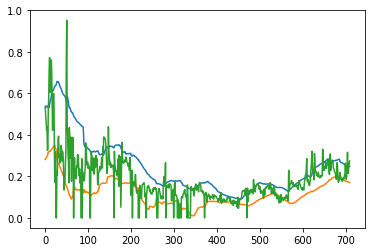

In [12]:
import matplotlib.pyplot as plt
plt.plot(Upp_Bnd[0])
plt.plot(Low_Bnd[0])
plt.plot(price['frist_VSI'].values[78:(MA.shape[1]+78)])
plt.show()